# Export detectron2 model to onnx format

A preliminary example of getting weights from detectron2 to onnx format. Its very hacky, but could be scriptable I suppose.

Based upon instructions at https://medium.com/@frankvanpaassen3/how-to-optimize-custom-detectron2-models-with-tensorrt-2cd710954ad3
and:
 https://github.com/NVIDIA/TensorRT/tree/main/samples/python/detectron2#detectron-2-mask-r-cnn-r50-fpn-3x-in-tensorrt

In [1]:
import os.path as osp

# We need a .cfg file containing the detectron2 model parameters used for training
cfg_filename = './isaid_cfg.yaml'

# And we need a .pth file containing the fine-tuned weights from our training
weights_filename = './model_final.pth'

# And we need a samle image to "anchor the converted model".
# This should come from the COCO dataset and have at least one classifiable obect in it.
sample_image_filename = './sample.jpg'

# Set up a filename to resample the sample image to
rs_root, rs_ext = osp.splitext(sample_image_filename)
resample_image_filename = rs_root + '_rs' + rs_ext

# Do things on cpu or cuda? (CUDA is overkill for what this is doig right now)
device = 'cpu'

# Set up an output path for the onnx model
output_path = './model.onnx'

In [2]:
# Install some stuff for this testing notebook
!pip install onnx netron

# We'll need to modify some detectron2 scripts so clone the repo locally first
# Later on we can include the required and modified script as a library in this repo
!git clone https://github.com/facebookresearch/detectron2.git
!pip install ./detectron2

fatal: destination path 'detectron2' already exists and is not an empty directory.


/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


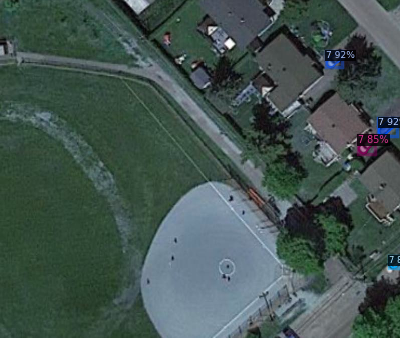

In [3]:
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from PIL import Image

# Look at the sample image and check that it has at least 1
# object detectable by the model.
# This is apparently required by the conversion to
# 'anchor the onnx model' ... whatever that means?

# First load the input model and check that at least one class is predicted
# in the image.
cfg = get_cfg()
cfg.merge_from_file(cfg_filename)
cfg.MODEL.WEIGHTS = weights_filename  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.DEVICE = device
predictor = DefaultPredictor(cfg)

im1 = cv2.imread(sample_image_filename)
outputs = predictor(im1)
v = Visualizer(im1[:, :, ::-1], scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

Image.fromarray(out.get_image()[:, :, ::-1])

In [4]:
# This horrible hack, as described in the websites linked in the header
# upon which this notebook is based may not actually be required since
# it refers to being required for TensorRT export after onnx export -
# but in the end we may want this anyhow so I'm leaving it in to see
# how it goes to see if I understand things better.

# Need to hardcode sample_image size to 1334x1334
export_script = open("./detectron2/tools/deploy/export_model.py", "r")
script_lines = export_script.readlines()
script_lines[165] = "    [1344, 1344], 1344 \n"

export_script = open("./export_model.py", "w")
export_script.writelines(script_lines)
export_script.close()

# Resample the sample_image to 1344x1344 as well
im2 = cv2.resize(im1, [1344, 1344])
cv2.imwrite(resample_image_filename, im2)



True

In [6]:
# Run our modified export_model script to get a model.onnx file
!python ./export_model.py \
--config-file $cfg_filename \
--output $output_path \
--format onnx \
--sample-image $resample_image_filename \
--export-method tracing \
MODEL.DEVICE $device MODEL.WEIGHTS $weights_filename


[09/14 11:57:29 detectron2]: Command line arguments: Namespace(format='onnx', export_method='tracing', config_file='./isaid_cfg.yaml', sample_image='./sample_rs.jpg', run_eval=False, output='model.onnx', opts=['MODEL.DEVICE', 'cpu', 'MODEL.WEIGHTS', './model_final.pth'])
[W init.cpp:836] Warning: Use _jit_set_fusion_strategy, bailout depth is deprecated. Setting to (STATIC, 1) (function operator())
[09/14 11:57:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./model_final.pth ...
/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3.9/site-packages/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/Users/tmau0037/miniconda3/envs/torch2onnx/lib/python3

In [14]:
# Now there should be an onnx model in onnx.model in the output dir
# Try and visualise the graph with netron (can take a bit of time to load)
import netron
import IPython

# Read the model file and start the netron browser.
netron.start('./model.onnx/model.onnx', 8080, browse=False)
IPython.display.IFrame("http://localhost:8080", height=800, width=1000)

Stopping http://localhost:8080
Serving './model.onnx/model.onnx' at http://localhost:8080
